#### Introduction

Heart failure occurs when the damaged or weakened heart muscle is unbale to pump blood efficiently to meet body’s needs. According to mayo clinic, the risk factors of heart failure include but not limited to high blood pressure, diabetes, and smoking. This leads to the question of which predictor(s) are good for a model where given the information of a heart failure patient, are they going to survive or not after some period of time. To answer this question, we will build models to analyze the “Heart Failure Prediction” dataset on Public Library of Science, authoured by Tanvir Ahmad, Assia Munir, Sajjad Haider Bhatti, Muhammad Aftab, Muhammad Ali Raza in 2017. The 11 predictors we will use from the dataset are:
* The patient’s age 
* Whether they have anaemia
* Creatinine phosphokinase level in blood
* Whether they have diabetes
* Ejection fraction (percentage of blood leaving the heart at each contraction)
* If the patient has high blood pressure
* Platelets level in blood
* Level of serum creatinine in blood
* Level of serum sodium in blood
* Sex (binary)
* If the patient smokes

Preliminary Exploratory Data Analysis

In [2]:
# import libraries for R functions

library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [11]:
# load data from the web
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00519/heart_failure_clinical_records_dataset.csv"
original_data <- read_csv(url)
original_data

Rows: 299 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (13): age, anaemia, creatinine_phosphokinase, diabetes, ejection_fractio...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
75,0,582,0,20,1,265000,1.9,130,1,0,4,1
55,0,7861,0,38,0,263358,1.1,136,1,0,6,1
65,0,146,0,20,0,162000,1.3,129,1,1,7,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
45,0,2060,1,60,0,742000,0.8,138,0,0,278,0
45,0,2413,0,38,0,140000,1.4,140,1,1,280,0
50,0,196,0,45,0,395000,1.6,136,1,1,285,0


In [146]:
# turn binary variables into factors

original_data <- original_data |>
    mutate(anaemia = as_factor(anaemia),
          diabetes = as_factor(diabetes),
          high_blood_pressure = as_factor(high_blood_pressure),
          platelets_num_per_mL = platelets/1000,
          sex = as_factor(sex),
          smoking = as_factor(smoking),
          DEATH_EVENT = as_factor(DEATH_EVENT))

# man is 1 in sex, woman is 0 since the paper said 194 men and 105 women, filtering for sex == 1 gives as 194 rows


In [147]:
# split the data into training and testing sets

set.seed(1625)

# split the data for 75% training and 25% testing, roughly same ratio of survived to dead in both sets as the original
data_split <- initial_split(original_data, prop = 0.75, strata = DEATH_EVENT)
training_data <- training(data_split)
testing_data <- testing(data_split)

In [179]:
# finding summary data of the training set

# mean of numerical predictors among survived or dead patients

numerical_preds <- c("Age", "Creatinine phosphokinase", "Ejection fraction", "Platelets (number/mL)", "Serum creatinine",
                    "Serum sodium", "Follow-up period length")

# make a function to find the mean of the numerical predictors among the survived patients
find_mean_survived <- function(dat) {
    
    result_list <- c()
    
    num_pred_only_data <- dat |> select(age, creatinine_phosphokinase, ejection_fraction, platelets_num_per_mL, 
                                        serum_creatinine, serum_sodium, time, DEATH_EVENT)
    
    for (i in 1:7) {
        
        curr_column <- num_pred_only_data[,i]
        death_event_column <- num_pred_only_data[,length(num_pred_only_data)]
        grouped_columns <- bind_cols(curr_column, death_event_column)
        as_tibble(grouped_columns)
        colnames(grouped_columns) <- c("Predictor", "Response")
        as_factor(grouped_columns$Response)
        
        result_list[i] <- mean(filter(grouped_columns, Response == 0)$Predictor, na.rm = TRUE)
        #mean_summary_dead[i] <- mean(filter(grouped_columns, Response == 1)$Predictor, na.rm = TRUE)
        
    }
    
    result_list
        
}


# make a function to find the mean of the numerical predictors among the dead patients
find_mean_dead <- function(dat) {
    
    result_list <- c()
    
    num_pred_only_data <- dat |> select(age, creatinine_phosphokinase, ejection_fraction, platelets_num_per_mL, 
                                        serum_creatinine, serum_sodium, time, DEATH_EVENT)
    
    for (i in 1:7) {
        
        curr_column <- num_pred_only_data[,i]
        death_event_column <- num_pred_only_data[,length(num_pred_only_data)]
        grouped_columns <- bind_cols(curr_column, death_event_column)
        as_tibble(grouped_columns)
        colnames(grouped_columns) <- c("Predictor", "Response")
        as_factor(grouped_columns$Response)
        
        result_list[i] <- mean(filter(grouped_columns, Response == 1)$Predictor, na.rm = TRUE)
        
    }
    
    result_list
        
}

# find the mean for each numerical predictors among the survived patients
mean_summary_survived <- find_mean_survived(training_data)

# find the mean for each numerical predictors among the dead patients
mean_summary_dead <- find_mean_dead(training_data)



# make a function to find the percentage of survived patients for each category of categorial variables

categorical_preds <- c("Anaemia", "No anameia", "Diabetes", "No diabetes", "High blood pressure", 
                       "No high blood pressure", "Male", "Female", "Smoker", "Non-smoker")


find_ratio_yes <- function(dat) {
    
    result_list <- c()
    
    categ_pred_only_data <- dat |> 
        select(anaemia, diabetes, high_blood_pressure, sex, smoking, DEATH_EVENT)
    
    for (i in 1:5) {
        
        curr_column <- categ_pred_only_data[,i]
        death_event_column <- categ_pred_only_data[,length(categ_pred_only_data)]
        grouped_columns <- bind_cols(curr_column, death_event_column)
        as_tibble(grouped_columns)
        
        colnames(grouped_columns) <- c("Predictor", "Response")
        
        as_factor(grouped_columns$Predictor)
        as_factor(grouped_columns$Response)
        
        
        filtered_response_yes <- filter(grouped_columns, Predictor == 1)[,2]

        number_survived_yes <- nrow(filter(filtered_response_yes, Response == 0))
        
        result_list[i] <- number_survived_yes/nrow(filtered_response_yes)*100
        
    }
    
    result_list
        
}



find_ratio_no <- function(dat) {
    
    result_list <- c()
    
    categ_pred_only_data <- dat |> 
        select(anaemia, diabetes, high_blood_pressure, sex, smoking, DEATH_EVENT)
    
    for (i in 1:5) {
        
        curr_column <- categ_pred_only_data[,i]
        death_event_column <- categ_pred_only_data[,length(categ_pred_only_data)]
        grouped_columns <- bind_cols(curr_column, death_event_column)
        as_tibble(grouped_columns)
        
        colnames(grouped_columns) <- c("Predictor", "Response")
        
        as_factor(grouped_columns$Predictor)
        as_factor(grouped_columns$Response)
        
        
        filtered_response_no <- filter(grouped_columns, Predictor == 0)[,2]

        number_survived_no <- nrow(filter(filtered_response_no, Response == 0))
        
        result_list[i] <- number_survived_no/nrow(filtered_response_no)*100
        
    }
    
    result_list
        
}

ratio_summary_yes <- find_ratio_yes(training_data)

ratio_summary_no <- find_ratio_no(training_data)

ratio_summary <- c(ratio_summary_yes[1], ratio_summary_no[1],
                   ratio_summary_yes[2], ratio_summary_no[2],
                   ratio_summary_yes[3], ratio_summary_no[3],
                   ratio_summary_yes[4], ratio_summary_no[4],
                   ratio_summary_yes[5], ratio_summary_no[5])


In [173]:
# Create summary table 1
table_1 <- tibble(numerical_preds, round(mean_summary_survived, 4), round(mean_summary_dead, 4))
colnames(table_1) <- c("Predictor", "Mean of survived patients", "Mean of dead patients")
head(table_1, 7)

Predictor,Mean of survived patients,Mean of dead patients
<chr>,<dbl>,<dbl>
Age,59.2675,65.5232
Creatinine phosphokinase,521.2368,612.4583
Ejection fraction,40.4408,33.5694
⋮,⋮,⋮
Serum creatinine,1.2170,1.8928
Serum sodium,136.8684,135.1389
Follow-up period length,164.6447,74.0139


In [189]:
# Create summary table 2
table_2 <- tibble(categorical_preds, round(ratio_summary, 4))
colnames(table_2) <- c("Predictor", "Percentage of survived patients")
head(table_2, 10)

Predictor,Percentage of survived patients
<chr>,<dbl>
Anaemia,62.3656
No anameia,71.7557
Diabetes,68.4783
⋮,⋮
Female,64.1975
Smoker,70.8333
Non-smoker,66.4474


$x
[1] "Blood serum creatinine level (mg/dL)"

$fill
[1] "Survival status"

attr(,"class")
[1] "labels"

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



$x
[1] "Ejection fraction"

$fill
[1] "Survival status"

attr(,"class")
[1] "labels"

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



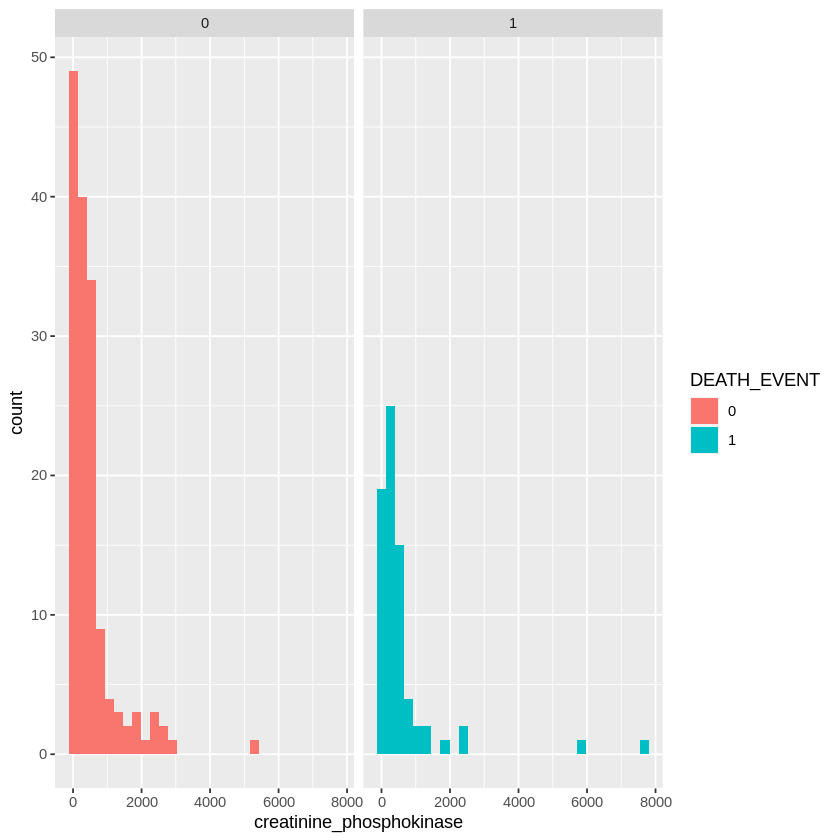

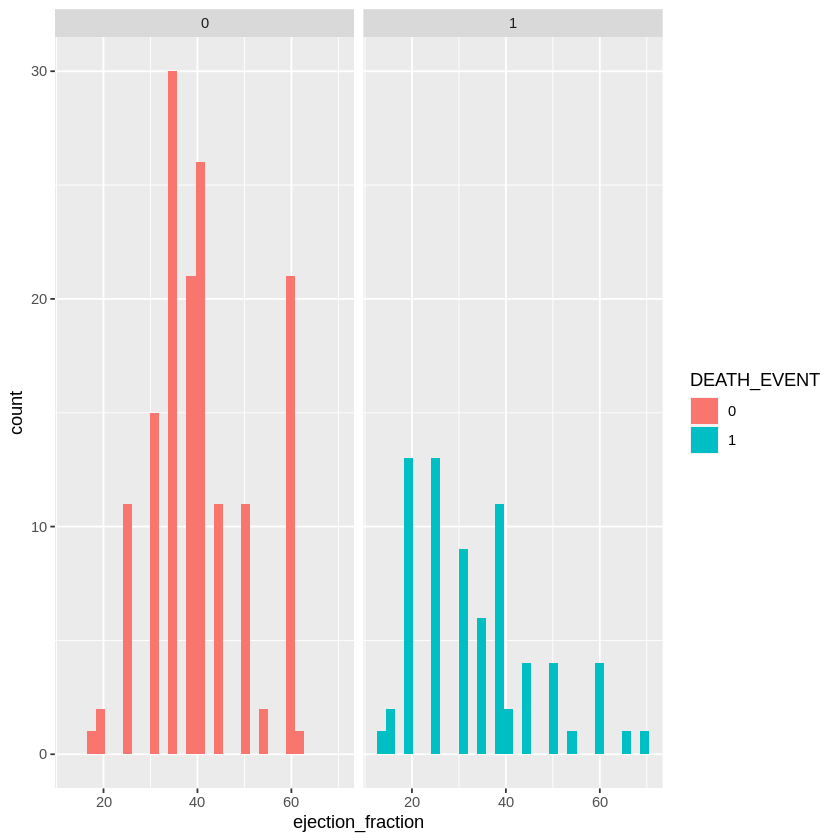

In [200]:
# Plots

plot1 <- training_data |>
    ggplot(aes(x = creatinine_phosphokinase, fill = DEATH_EVENT)) +
    geom_histogram() +
    facet_grid(~DEATH_EVENT)
    labs(x = "Blood serum creatinine level (mg/dL)",
         fill = "Survival status")

plot1

plot2 <- training_data |>
    ggplot(aes(x = ejection_fraction, fill = DEATH_EVENT)) +
    geom_histogram() +
    facet_grid(~DEATH_EVENT)
    labs(x = "Ejection fraction",
         fill = "Survival status")

plot2